# Predict ligand profiling using `kissim`

## Aim of this notebook

In order to asses the predictive power of `kissim`, we here choose a ligand-centric evaluation. We will compare if `kissim` can predict on- and off-targets determined in ligand profiling studies.

__Data__

- __Ligand-kinase profiling__: Karaman dataset downloaded from KinMap
- __Kinase-kinase profiling__: `kissim` dataset (kinase similarities)
- __Kinase names__: KinMap kinase names (maps kinase synonyms to main kinase names used in KinMap)
- __Ligand names__: PKIDB ligand names (maps ligand synonyms to main ligand names defined in PKIDB)

__Method__

- Prepare datasets
  - PDKIDB dataset: Ligand names
  - KinMap dataset: Kinase names
  - Karaman dataset: Ligand-kinase profiling data downloaded from KinMap (keep only ligands whose name can be cast to PKIDB name)
  - `kissim` dataset: Kinase-kinase profiling data (keep only kinases whose name can be cast to KinMap name)
  - Define ligands' on-targets as listed in PKIDB (keep only on-targets whose name can be cast to KinMap name)
- Merge datasets into "ligand dataset" per ligand; keep "ligand dataset" if enough coverage
  - "Ligand dataset" consists of
    - Ligand profiling data (Karaman et al. activities for ligand)
    - Kinase similarity data (`kissim` distances for ligand's on-target)
  - Coverage of a "ligand dataset" is high enough if the number of targets that fullfil the following conditions is greater than `MIN_N_TARGETS`:
    - Target is active w.r.t. to the ligand (in Karaman dataset; `KD_CUTOFF` defines activity)
    - Target is structurally covered in `kissim`
  - Some ligands have multiple on-targets; set up "ligand dataset" per ligand/on-target pair each
- Calculate `kissim` performance; measured using an enrichment factor within the top x% of ranked `kissim` results ($EF{_x\%}$)
  - Kinase is defined as active if Karaman et. al profiling data reports $K_d$ <= `KD_CUTOFF`
  - $EF{_x\%}$ is the ratio between _observed_ active kinases and the _theoretical maximum_ of active kinases in the top x% of ranked `kissim` results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown

from src.data import profiling, distances, targets
from src.evaluation import kinase_ranks, enrichment

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data"
RESULTS = HERE / "../../results"

## Define parameters

In [5]:
LIGAND_PROFILING_METHOD = "karaman"
KINASE_DISTANCES_METHOD = "kissim"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

## Prepare datasets

We want to compare on- and off-targets seen in (1) a kinase-ligand profiling dataset and (2) a kinase-kinase profiling dataset. 
Kinase names and ligand names must be homogenized; we will use kinase names from KinMap and ligand names from the PKIDB.

### Kinase-ligand profiling dataset

__Criteria__:

- Load dataset with FDA-approved PKIDB ligands only.
- Filters out ligands whose names cannot be mapped onto PKIDB ligand names.

In [6]:
# Full dataset (reported only, not further used)
karaman_df = profiling.karaman()
print(f"Number of kinases (full dataset): {karaman_df.shape[0]}")
print(f"Number of ligands (full dataset): {karaman_df.shape[1]}")

Number of kinases (full dataset): 268
Number of ligands (full dataset): 30


In [7]:
# Reduced dataset
karaman_df = profiling.karaman(pkidb_ligands=True, fda_approved=True)
print(f"Number of kinases (FDA-approved PKIDB ligands only): {karaman_df.shape[0]}")
print(f"Number of ligands (FDA-approved PKIDB ligands only): {karaman_df.shape[1]}")
karaman_df.head()

Changed ligand names (unknown names may be discarded - see function docstring):
           ligand.input            ligand.pkidb
0         Staurosporine  unknown (not in PKIDB)
1           JNJ-7706621  unknown (not in PKIDB)
2              MLN-8054  unknown (not in PKIDB)
3               PKC-412             Midostaurin
4              SU-14813  unknown (not in PKIDB)
5             SB-202190  unknown (not in PKIDB)
6             CP-724714  unknown (not in PKIDB)
7        VX-680/MK-0457  unknown (not in PKIDB)
9   Roscovitine/CYC-202  unknown (not in PKIDB)
10            SB-203580  unknown (not in PKIDB)
12            CP-690550             Tofacitinib
14              GW-2580  unknown (not in PKIDB)
16            GW-786034  unknown (not in PKIDB)
18               VX-745            Neflamapimod
19            SB-431542  unknown (not in PKIDB)
20              ZD-6474              Vandetanib
22         Flavopiridol  unknown (not in PKIDB)
24              MLN-518              Tandutinib
25      

Number of kinases (FDA-approved PKIDB ligands only): 268
Number of ligands (FDA-approved PKIDB ligands only): 16


,Midostaurin,Dasatinib,Gefitinib,Tofacitinib,Imatinib,Lapatinib,Sorafenib,Neflamapimod,Vandetanib,Sunitinib,Erlotinib,Tandutinib,Ruboxistaurin,Canertinib,Pelitinib,Vatalanib
AAK1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1200.0,NaN,900.0,NaN,3500.0,NaN
ABL1,NaN,0.53,NaN,NaN,12.0,NaN,680.0,730.0,270.0,830.0,310.0,NaN,NaN,1400.0,560.0,NaN
ABL2,NaN,0.17,NaN,NaN,10.0,NaN,2900.0,1900.0,69.0,1000.0,200.0,NaN,NaN,870.0,370.0,NaN
ALK2,NaN,620.00,NaN,NaN,NaN,NaN,NaN,NaN,150.0,NaN,NaN,2500.0,NaN,1700.0,NaN,NaN
ALK4,NaN,330.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


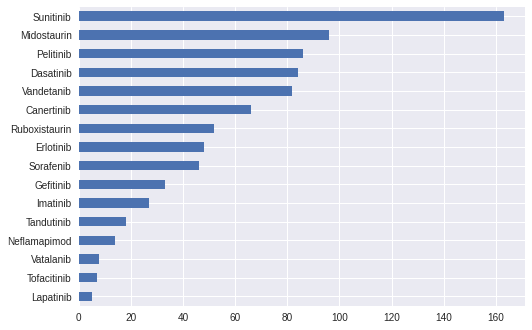

In [8]:
karaman_df.count().sort_values().plot(kind="barh");

### Kinase-kinase similarity dataset

__Criteria__: 

- Filters out kinases whose names cannot be mapped to KinMap kinase names.

In [9]:
# Full dataset (reported only, not further used)
kissim_df = distances.kissim(structure_kinase_mapping_by="minimum", kinmap_kinases=False)
print(f"Kinase distance matrix shape: {kissim_df.shape}")

Kinase distance matrix shape: (292, 292)


In [10]:
# Reduced dataset
kissim_df = distances.kissim(structure_kinase_mapping_by="minimum", kinmap_kinases=True)
print(f"Kinase distance matrix shape: {kissim_df.shape}")
kissim_df.iloc[:5, :5]

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
73         DCLK1                  DCAMKL1
133       JAK1-b                   JAK1_b
135       JAK2-b                   JAK2_b
176       MSK1-b                   MSK1_b
200       PI4K2A  unknown (not in KinMap)
201       PI4K2B  unknown (not in KinMap)
202        PI4KB  unknown (not in KinMap)
203       PIK3C3  unknown (not in KinMap)
236       RSK1-b                   RSK1_b
238       RSK2-b                   RSK2_b
267       TYK2-b                   TYK2_b
284        p110a  unknown (not in KinMap)
285        p110d  unknown (not in KinMap)
286        p110g  unknown (not in KinMap)


Kinase distance matrix shape: (285, 285)


,AAK1,ABL1,ABL2,ACK,ACTR2
AAK1,0.000000,0.239739,0.246362,0.246718,0.261379
ABL1,0.239739,0.000000,0.032393,0.137668,0.280255
ABL2,0.246362,0.032393,0.000000,0.148981,0.294966
ACK,0.246718,0.137668,0.148981,0.000000,0.293667
ACTR2,0.261379,0.280255,0.294966,0.293667,0.000000


### Ligands' on-targets dataset

__Criteria__: 

- Filters out ligands that are not available in the PKIDB or have no targets in the PKIDB.
- Filters out targets whose names cannot be mapped onto KinMap names

In [11]:
pd.set_option("max_colwidth", 100)
ligand_targets = targets.pkidb(karaman_df.columns, fda_approved=False)
ligand_targets

Changed kinase names (unknown names may be discarded - see function docstring):
   kinase.input            kinase.kinmap
0           nan  unknown (not in KinMap)
3         EPHA2                    EphA2
5          YES1                      YES
7        PDGFRB                   PDGFRb
17        NTRK1                     TRKA
18        CSF1R                      FMS
19       PDGFRA                   PDGFRa
22       PDGFRB                   PDGFRb
24        ERBB2                    ErbB2
30       PDGFRB                   PDGFRb
35       MAPK14                     p38a
36        VEGFA  unknown (not in KinMap)
38         PTK6                      BRK
39          TEK                     TIE2
41       PDGFRB                   PDGFRb
47        CSF1R                      FMS
48       PDGFRA                   PDGFRa
50        NR1I2  unknown (not in KinMap)
52        PDGFD  unknown (not in KinMap)
53          nan  unknown (not in KinMap)
56        ERBB2                    ErbB2


,ligand.input,targets.pkidb,targets.kinmap
0,Canertinib,[EGFR],[EGFR]
1,Erlotinib,[EGFR],[EGFR]
2,Gefitinib,[EGFR],[EGFR]
3,Neflamapimod,[MAPK14],[p38a]
4,Tandutinib,[FLT3],[FLT3]
5,Lapatinib,"[EGFR, ERBB2]","[EGFR, ErbB2]"
6,Pelitinib,"[EGFR, ERBB2]","[EGFR, ErbB2]"
7,Vatalanib,"[FLT1, KDR, FLT4]","[FLT1, KDR, FLT4]"
8,Tofacitinib,"[JAK1, JAK2, JAK3, TYK2]","[JAK1, JAK2, JAK3, TYK2]"
9,Vandetanib,"[EGFR, PTK6, TEK, RET]","[EGFR, BRK, TIE2, RET]"


Ligand targets listed in the DrugBank or PKIDB may include on- and off-targets. 

For the purpose of this notebook, we would like to identify the intended targets (on-targets) only. This seems to be a not-so-easy task and involves a manual assignment based on literature search.

We will assign main on-targets manually based on the following table including
- Main on-targets reported in literature
- Use KinMap kinase names (since we are using the Karaman dataset provided by KinMap)
- For multitargeted ligands define multiple targets

| Approved kinase inhibitor                            | Intended kinase target |
|------------------------------------------------------|---------------------------------------------------------|
| [Erlotinib](https://go.drugbank.com/drugs/DB00530)   | EGFR |
| [Gefitinib](https://go.drugbank.com/drugs/DB00317)   | EGFR |
| [Lapatinib](https://go.drugbank.com/drugs/DB01259)   | EGFR, ERBB2 |
| [Tofacitinib](https://go.drugbank.com/drugs/DB08895) | JAK1, JAK2, JAK3 |
| [Vandetanib](https://go.drugbank.com/drugs/DB05294)  | VEGFR2, EGFR, RET; [see paper](https://www.ema.europa.eu/en/documents/assessment-report/caprelsa-epar-public-assessment-report_en.pdf) |
| [Imatinib](https://go.drugbank.com/drugs/DB00619)    | multitargeted inhibitor - TK: ABL1, KIT, PDGFRa; [see paper](https://www.hindawi.com/journals/cherp/2014/357027/) |
| [Sunitinib](https://go.drugbank.com/drugs/DB01268)   | multitargeted inhibitor - TK: VEGFR1/2, PDFGRa/b, KIT, FLT2, RET, CSF1R; [see paper](https://link.springer.com/article/10.2165/11318860-000000000-00000) |
| [Dasatinib](https://go.drugbank.com/drugs/DB01254)   | multitargeted inhibitor - TK: ABL1 (BCRABL), SRC, Eph\_ (Ephrins), \_GFR (GFR); see DrugBank Identification > Description |
| [Sorafenib](https://go.drugbank.com/drugs/DB00398)   | multitargeted inhibitor - TK/TKL (Raf/Mek/Erk pathways): RAF\_ (Raf) \[TKL\], PDFGR\_ (PDFG), VEGF2/3, KIT; see DrugBank Identification > Description |

Full ligand-kinase list:

### Ligand-kinase datasets

We merge now profiling and kinase similarity information into one dataset per ligand-kinase pair (_ligand-kinase dataset_). 

We only keep ligand-kinase pairs that
- have a minimum of `MIN_N_SHARED_KINASES` shared kinases
- have a minimum of `MIN_N_SHARED_ACTIVE_KINASES` shared active kinases, while activity is defined <= `KINASE_ACTIVITY_CUTOFF`

#### Ligand-kinase dataset for example ligand-kinase pair

In [12]:
ranks, _ = kinase_ranks.kinase_ranks_by_ligand_vs_kinase_data(
    "Erlotinib", "EGFR", karaman_df, kissim_df, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, KINASE_ACTIVITY_CUTOFF, kinase_activity_max=True
)
ranks.head()

,karaman.measure,karaman.active,karaman.rank1,karaman.rank2,kissim.measure,kissim.rank1,kissim.rank2
kinase,,,,,,,
EGFR,0.67,True,1.0,1.0,0.000000,1.0,1.0
ErbB4,230.00,False,7.0,6.0,0.058818,2.0,2.0
ABL1,310.00,False,9.0,8.0,0.136113,8.0,3.0
RET,1300.00,False,28.5,20.5,0.139980,10.0,4.0
EphA3,2400.00,False,40.0,29.0,0.143503,12.0,5.0


#### Select ligand-kinase pairs with enough coverage

In [13]:
ligand_kinase_pairs = (
    ligand_targets[["ligand.input", "targets.kinmap"]]
    .explode("targets.kinmap")
    .to_numpy()
    .tolist()
)
print(f"Number of pairs (full dataset): {len(ligand_kinase_pairs)}")

ligand_kinase_pairs_selected = kinase_ranks.curate_ligand_kinase_pairs(
    ligand_kinase_pairs,
    karaman_df,
    kissim_df,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    min_n_shared_kinases=MIN_N_SHARED_KINASES,
    min_n_shared_active_kinases=MIN_N_SHARED_ACTIVE_KINASES,
)
print(f"Number of pairs (filtered dataset): {len(ligand_kinase_pairs_selected)}")

Number of pairs (full dataset): 55
Number of pairs (filtered dataset): 41


## Calculate `kissim` performance

How do we assess the performance of `kissim` based on our merged Karaman-`kissim` datasets (ligand datasets)?

### Enrichment factor 

$EF_{x\%} = \frac{a}{b}$

- $a$: Ratio of active targets in `kissim`'s top x% ranks
- $b$: Ratio of active targets in all `kissim` ranks

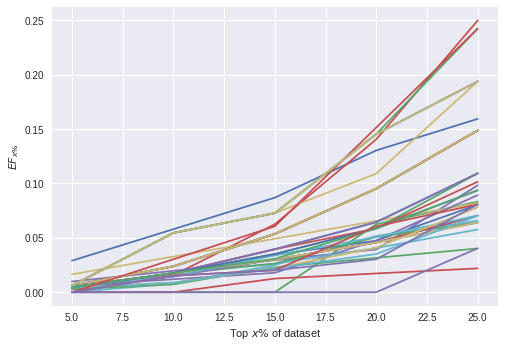

In [14]:
enrichment_factor_list = []
for ligand_name, kinase_name in ligand_kinase_pairs_selected:
    ranks, _ = kinase_ranks.kinase_ranks_by_ligand_vs_kinase_data(
        ligand_name, kinase_name, karaman_df, kissim_df, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, KINASE_ACTIVITY_CUTOFF, KINASE_ACTIVITY_MAX
    )
    ef5 = enrichment.enrichment_factor(ranks, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, cutoff_percentage=5)
    ef10 = enrichment.enrichment_factor(ranks, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, cutoff_percentage=10)
    ef15 = enrichment.enrichment_factor(ranks, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, cutoff_percentage=15)
    ef20 = enrichment.enrichment_factor(ranks, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, cutoff_percentage=20)
    ef25 = enrichment.enrichment_factor(ranks, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, cutoff_percentage=25)
    enrichment_factor_list.append([ligand_name, kinase_name, ef5, ef10, ef15, ef20, ef25])
    
enrichment_factors = pd.DataFrame(enrichment_factor_list, columns=["ligand", "kinase", 5, 10, 15, 20, 25])
enrichment_factors = enrichment_factors.set_index(["ligand", "kinase"])
ax = enrichment_factors.transpose().plot(legend=False)
ax.set_xlabel("Top $x\%$ of dataset")
ax.set_ylabel("$EF_{x\%}$");

### Enrichment plots

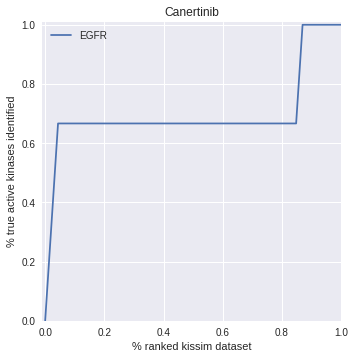

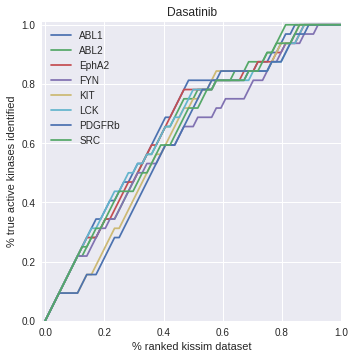

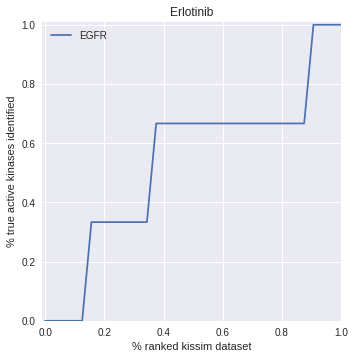

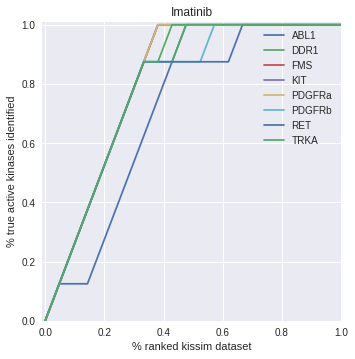

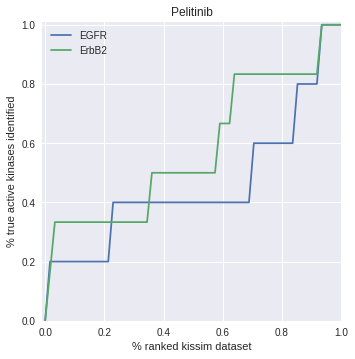

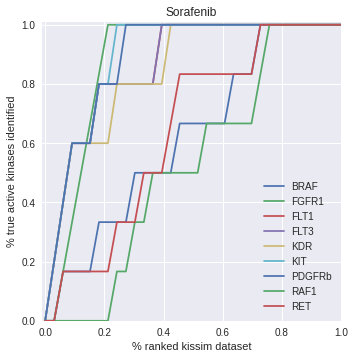

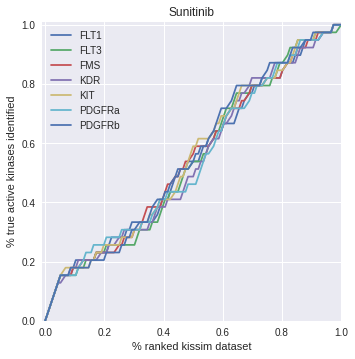

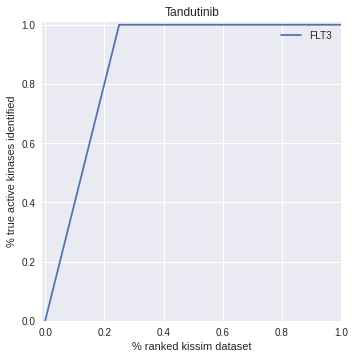

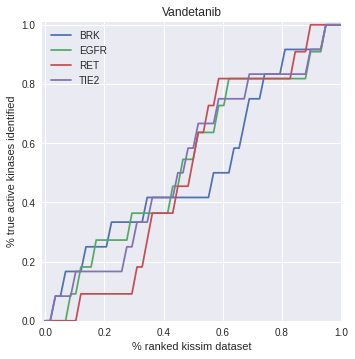

In [15]:
enrichment_data_list = []
for ligand_name, kinase_name in ligand_kinase_pairs_selected:
    ranks, _ = kinase_ranks.kinase_ranks_by_ligand_vs_kinase_data(
        ligand_name, kinase_name, karaman_df, kissim_df, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, KINASE_ACTIVITY_CUTOFF, KINASE_ACTIVITY_MAX
    )
    enrichment_data = [enrichment.enrichment(ranks, LIGAND_PROFILING_METHOD, KINASE_DISTANCES_METHOD, i) for i in range(0, 101, 1)]
    enrichment_data_list.append([ligand_name, kinase_name, enrichment_data])
    
enrichment_data = pd.DataFrame(enrichment_data_list, columns=["ligand", "kinase", "data"]).explode("data")
enrichment_data["x"] = enrichment_data["data"].apply(lambda x: x[1])
enrichment_data["y"] = enrichment_data["data"].apply(lambda x: x[0])
enrichment_data = enrichment_data.drop("data", axis=1)
enrichment_data

data = {}
for ligand_name, data1 in enrichment_data.groupby("ligand"):
    data[ligand_name] = []
    for kinase_name, data2 in data1.groupby("kinase"):
        data_tmp = data2.set_index("x")["y"]
        data_tmp.name = kinase_name
        data[ligand_name].append(data_tmp)
    data[ligand_name] = pd.concat(data[ligand_name], axis=1)

for ligand_name, df in data.items():
    # Experimental curves
    ax = data[ligand_name].plot(title=ligand_name, ylim=(0, 1.01), xlim=(-0.01, 1))
    # Optimal curve for ligand
    #ligand_dataset = create_ligand_dataset(karaman_df, kissim_df, ligand_name, kinase_name, KD_CUTOFF)
    #ax.plot([0, enrichment_optimal(ligand_dataset), 1], [0, 1, 1], "--", color="k")
    # Cosmetics
    ax.set_xlabel("% ranked kissim dataset")
    ax.set_ylabel("% true active kinases identified")
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")